<a href="https://colab.research.google.com/github/wfwiggins/RSNA-Image-AI-2020/blob/master/RSNA20_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RSNA 2020

## Interactive AI for Non-coders: Image Classification Basics for Beginners

This work is adapted from Lakhani et al. "Hello World Deep Learning in Medical Imaging." Journal of Digital Imaging. 2018 Jun;31(3):283-289 ([link to article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5959832/)). Data were obtained and the notebook adapted from Paras Lakhani's GitHub repository ([link to repo](https://github.com/paras42/Hello_World_Deep_Learning/tree/9921a12c905c00a88898121d5dc538e3b524e520)). Code has been modified to match the format and directory structure from the article. Additional modifications have been made with the intent to increase readability and facilitate understanding for participants at all levels of coding skill and experience.

To explore this model and data set, please _Save a Copy in Drive_ from the `File` menu above (i.e. save a copy in your Google Drive).

In this Notebook editing environment, each block of text is referred to as a **cell**.  Cells containing formatted text are **Markdown** cells, as they use the *Markdown* formatting language. Similarly, cells containing code are **code** cells.

Clicking within a cell will allow you to edit the content of that cell (a.k.a. enter **edit mode**). You can also navigate between cells with the arrow keys. Note that the appearance of Markdown cells will change when you enter edit mode.

You can **run code cells** (and format Markdown cells) as you go along by clicking within the cell and then clicking the **blue button with *one* arrow** next to the cell or at the bottom of the window. You can also use the keyboard shortcut <kbd>SHIFT</kbd> + <kbd>ENTER</kbd> (press both keys at the same time).

`Hello, world!` is a time-honored tradition in learning a new programming language. It refers to the initial exercise in any book or tutorial, where one is taught the **syntax** for printing the message "Hello, world!" to the **programming environment**'s *output display*. The syntax for executing this task in Python is included below.

In [ ]:
print("")    # insert the text "Hello, world!" between the quotes, then run the cell


Hello, world!


## 1. Loading Python modules
For the experiments that follow, we'll use the [**Python** programming language](https://www.python.org/) with the [**fast.ai**](https://fast.ai/) API, built on top of the [**PyTorch**](https://pytorch.org/) **library**.

In [ ]:
#@title **Setting up the environment**: This step will generate an error. This is expected and can safely be ignored.

import os

!pip install fastai --upgrade >/dev/null

os.kill(os.getpid(), 9)

In [6]:
#@title **Importing the data...**

!wget -q https://github.com/wfwiggins/RSNA-Image-AI-2020/blob/master/data.zip?raw=true
!mkdir -p data
!unzip -o data.zip?raw=true -d data >/dev/null
!rm data.zip?raw=true

## 2. Taking a look at the data
I've preloaded the data that we'll be using into this kernel. Let's take a look at the directory structure and contents, then create some variables to help us as we proceed.

In [7]:
from fastai.basics import *

# Set path variable to the directory where the data is located
path = Path('/content/data')

# Command line "magic" command to show directory contents
!ls {path}/*/*


/content/data/test/abd_test.png  /content/data/test/chest_test.png

/content/data/train/abd:
abd0.png   abd14.png  abd19.png  abd23.png  abd28.png  abd3.png  abd8.png
abd10.png  abd15.png  abd1.png	 abd24.png  abd29.png  abd4.png  abd9.png
abd11.png  abd16.png  abd20.png  abd25.png  abd2.png   abd5.png
abd12.png  abd17.png  abd21.png  abd26.png  abd30.png  abd6.png
abd13.png  abd18.png  abd22.png  abd27.png  abd31.png  abd7.png

/content/data/train/chst:
chst33.png  chst39.png	chst45.png  chst51.png	chst57.png  chst63.png
chst34.png  chst40.png	chst46.png  chst52.png	chst58.png  chst64.png
chst35.png  chst41.png	chst47.png  chst53.png	chst59.png  chst65.png
chst36.png  chst42.png	chst48.png  chst54.png	chst60.png
chst37.png  chst43.png	chst49.png  chst55.png	chst61.png
chst38.png  chst44.png	chst50.png  chst56.png	chst62.png

/content/data/val/abd:
abd0.png  abd1.png  abd2.png  abd3.png	abd4.png

/content/data/val/chst:
abd0.png  abd1.png  abd2.png  abd3.png	abd4.png


As you can see, the `data` directory contains subdirectories `train`, `val` and `test`, which contain the *training*, *validation* and *test* data for our experiment. `train` and `val` contain subdirectories `abd` and `chst` containing abdominal and chest radiographs for each data set. There are 65 training images and 10 validation images with *balanced distributions* over our *target classes* (i.e. approximately equal numbers of abdominal and chest radiographs in each data set).

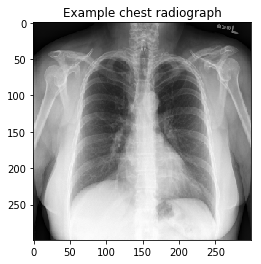

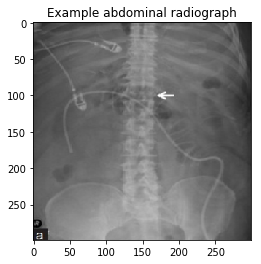

In [ ]:
# set variables for paths to directories for training & validation data
train_dir = path/'train'
val_dir = path/'val'

# set variables for number of samples in each data set
num_train = 65
num_val = 10

# we'll need to import additional modules to look at an example image
import numpy as np    # this is a standard convention
from keras.preprocessing import image
import matplotlib.pyplot as plt    # also by convention

# these are the dimensions of our images
img_width, img_height = 299, 299

# set the path to a chest radiograph, then load it and show
img_path = os.path.join(train_dir, 'chst/chst33.png')
img = image.load_img(img_path, target_size=(img_width, img_height))
plt.imshow(img)
plt.title('Example chest radiograph')
plt.show()

# set the path to an abdominal radiograph, then load it and show
img2_path = os.path.join(train_dir, 'abd/abd1.png')
img2 = image.load_img(img2_path, target_size=(img_width, img_height))
plt.imshow(img2)
plt.title("Example abdominal radiograph")
plt.show()


## 3. Setting up our generators & selecting hyperparameters
A neural network model consists of:
- An **architecture** defining the structure of the connections between **layers** of **artificial neurons (_units_)** in the network
    - *Within a layer*, units are NOT connected to each other (with some exceptions, not relevant to this module)
    - The connections that define the architecture are between neurons in *different layers* of the network
- The **weights** (*or* parameters) that determine the strength of those connections.

When training a model, we choose from a wide array of different **hyperparameters** that govern different aspects of the training process. Choosing these well is important for avoiding the phenomenon of **overfitting**, where the network is optimized to features in the training data set that are unique to those data, but not representative of the broader phenomenon you're trying to capture with your network. These features can be thought of as confounding variables. See [this article](https://towardsdatascience.com/overfitting-vs-underfitting-a-conceptual-explanation-d94ee20ca7f9) for a more detailed explanation of overfitting (and it's counterpart, underfitting).

>Common hyperparameters include:
- Number of training **epochs**: in each epoch of training, the model is exposed to each training sample exactly once
    - The more a network is exposed to each training sample, the higher the likelihood it will overfit
    - However, it is unlikely that you will achieve optimal performance after only one epoch of training
- Optimization algorithm: typically, a variation of stochastic gradient descent
    - Learning rate
    - Batch size (i.e. number of samples to evaluate for each update of the model's weights)
- Loss function: the measure of network performance used to adjust the model's weights in each training step
    - Regularization: a method of penalizing large weights to avoid overfitting
- Performance metric: the measure of network performance used to evaluate the network after each epoch of training is complete
- Data augmentation: a method of transforming the data in a way that helps prevent overfitting, but preserves the information contained in the data
    - Types of transformations
    - Magnitude of a given transformation
    - Probability of any given transformation occurring for a given sample

One of the more challenging aspects of training a network is selecting the optimal hyperparameters. Here, each participant will train the network with different hyperparameters, so that we can compare results and try to get a sense of the effects they have on training results. Some will experiment with **image augmentation**. Others will experiment with **dropout**.

In [ ]:
# randomize to groups 1 and 2
group = np.random.randint(1, 3)
print("You have been assigned to Group", group)


You have been assigned to Group 2


If you've been assigned to Group 1, please leave the following code cell alone and run it in its current state.

If you've been assigned to Group 2, please remove image augmentation in the code cell below the example by setting all of the arguments between the parentheses to `0` (or `False` for `horizontal_flip`) **with one exception.** Keep `rescale=1./255`.

Your `train_datagen` code should look like this:
```python
# EXAMPLE CODE -> NOT a functional code cell
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0,
        zoom_range=0,
        rotation_range=0,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False
)
```

**Make any edits in the code cell _below this line_.**

In [ ]:
# set the batch size for each training step
batch_size = 8

# create training data generator object
# initialize values for image augmentation
# rescaling is done to normalize the image pixel values into the [0, 1] range
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
)

print('Success!')


Success!


Once you've made your edits and see "Success!" as your output, you may run the code cell below.

In [ ]:
# finalize training generator
print("Training generator: ", end="")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# create validation data generator object
# no image augmentation here, as we are not training our model on this data
val_datagen = ImageDataGenerator(rescale=1./255)
print("Validation generator: ", end="")
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Training generator: Found 65 images belonging to 2 classes.
Validation generator: Found 10 images belonging to 2 classes.


## 4. Creating the model with transfer learning
We'll employ a technique called **transfer learning** with the `InceptionV3` model, using weights obtained by **pretraining** the model on the **ImageNet** data set.

In [ ]:
weights_path = '../input/keras-pretrained-models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
backbone = applications.InceptionV3(weights=weights_path, include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the pretrained weights in the model backbone
for layer in backbone.layers:
    layer.trainable = False

print('Model backbone initialized!')    # this will print when this step is complete


Model backbone initialized!


Here, we add custom top layers for our task to get the desired model output.

Adding a `GlobalAveragePooling2D` layer after the final **convolutional** layer in the `backbone` and a `Dropout` layer prior to the final layer are two additional methods employed to improve model performance and reduce overfitting. **Dropout** refers to the random elimination of the inputs from some proportion of the neurons in this layer.

After the architecture is established, the model must be **compiled** with the desired optimizer, loss function, and performance metric before training is initiated. Here, we use the Adam optimizer, binary cross-entropy as our loss function, and accuracy as our performance metric.

Some participants will be randomized to run their experiments **without** the `Dropout` layer, so that we can see the effect of dropout on our results.

In [ ]:
# randomize to subgroups A & B
subgroup = np.random.randint(1, 3)
print("You have been assigned to Subgroup", "A" if subgroup == 1 else "B")


You have been assigned to Subgroup B


If you've been assigned to Subgroup A, then please leave the following code cell alone and run it in its current state.

If you've been assigned to Subgroup B, then please **comment out** the line of code containing `Dropout`. This is done by placing a `#` prior to the line of code, such that it now should look like this. Alternatively, you can click anywhere on the line and use the keyboard shortcut <kbd>Ctrl</kbd> (<kbd>Cmd</kbd> on Mac) + <kbd>/</kbd> to *comment out the line*.

```python
# model_top.add(Dropout(0.5))
```

This will prevent the `Dropout` layer from being added to the model so that we may evaluate the effect of dropout on overfitting.

In [ ]:
# create the top layers of the model
model_top = Sequential()    # initialize as a Sequential model (i.e. no recurrent layers)
model_top.add(GlobalAveragePooling2D(input_shape=backbone.output_shape[1:], data_format=None)) 
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) # the output will be a probability

# connect "model_top" to "backbone"
model = Model(inputs=backbone.input, outputs=model_top(backbone.output))

# compile the model with the Adam optimizer, binary cross-entropy loss, and accuracy
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

print('Setup Complete!')


Setup Complete!


## 5. Training the model
Now, we will **train the model**. Since this will take several minutes and all of the code needs to be run again when the kernel is *committed* (see the blue <kbd>Commit</kbd> button near the top right of your screen), we'll start running the cell to see what the output looks like as the model is training, and then move on to reviewing the few remaining cells before committing the notebook to return later after our model is finished.

We start by training for **a few epochs** with the backbone *frozen* to avoid propagating large losses through the pretrained layers. If we didn't do this, we could potentially **degrade the higher-level features** in the early layers of the model that were so carefully pretrained on ImageNet...and we wouldn't want to do that.

>If you receive an **Error message** on this step, it is likely that the GPU functionality of the kernel has failed. Please **restart the kernel** by clicking the **blue button with 2 arrows** at the bottom of this screen next to <kbd>Console</kbd>. (Note: you will have to rerun all previous code cells prior to running this one again.) If this *does NOT* solve your problem, then you should set **GPU off** in the <kbd>Settings</kbd> panel on the right-hand side of this screen and try again. This will force the kernel to use its CPU, which will be slower but will still train the model.

In [ ]:
# set the number of epochs for training
epochs = 4

# train the model and save the training/validation results for each epoch to "history"
history = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=num_val // batch_size)

print('Training complete!')


Epoch 1/4
8/8 [==============================] - 9s 1s/step - loss: 0.6794 - acc: 0.5781 - val_loss: 0.5395 - val_acc: 0.7500
Epoch 2/4
8/8 [==============================] - 1s 103ms/step - loss: 0.6073 - acc: 0.6177 - val_loss: 0.5960 - val_acc: 0.5000
Epoch 3/4
8/8 [==============================] - 1s 72ms/step - loss: 0.6104 - acc: 0.6177 - val_loss: 0.6633 - val_acc: 0.6250
Epoch 4/4
8/8 [==============================] - 1s 163ms/step - loss: 0.5694 - acc: 0.7127 - val_loss: 0.3022 - val_acc: 1.0000
Training complete!


Now we will plot and evaluate the **training curves** for training the custom top layers of our model.

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


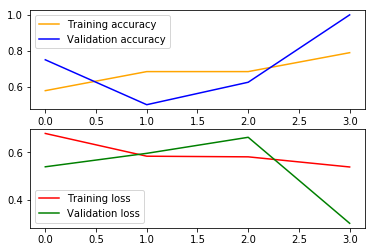

In [ ]:
print(history.history.keys())

fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['acc'], 'orange', label='Training accuracy')
ax[0].plot(history.history['val_acc'], 'blue', label='Validation accuracy')
ax[1].plot(history.history['loss'], 'red', label='Training loss')
ax[1].plot(history.history['val_loss'], 'green', label='Validation loss')
ax[0].legend()
ax[1].legend()
plt.show()


You should see in the plot above that our training and validation **losses** went *down* over the 4 epochs of training, while our training and validation **accuracy** went *up*.

Now, we can **unfreeze the model backbone** and train a little more to see if we can improve our performance.

In [ ]:
# Unfreeze the model backbone before we train a little more
for layer in model.layers:
    layer.trainable = True

# When you make a change to the model, you have to compile it again prior to training
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

print('Setup Complete!')


Setup Complete!


This should converge quickly, so we'll only train for **3 epochs** this time.

In [ ]:
# set the number of epochs for training
epochs = 3

# train the model and save the training/validation results for each epoch to "history"
history = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=num_val // batch_size)

print('Training complete!')


Epoch 1/3
8/8 [==============================] - 20s 3s/step - loss: 0.3246 - acc: 0.8553 - val_loss: 0.1485 - val_acc: 1.0000
Epoch 2/3
8/8 [==============================] - 1s 151ms/step - loss: 0.2253 - acc: 0.8869 - val_loss: 0.0285 - val_acc: 1.0000
Epoch 3/3
8/8 [==============================] - 1s 144ms/step - loss: 0.2295 - acc: 0.9525 - val_loss: 0.0075 - val_acc: 1.0000
Training complete!


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


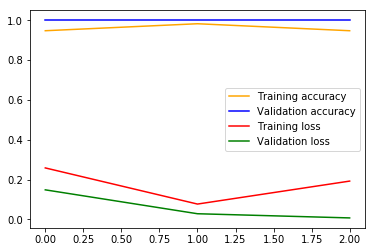

In [ ]:
print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()


## 6. Evaluating training results and model performance

Once training is finished, **evaluating the training curves** can help us **tune our hyperparameters** in subsequent experiments by telling us if we're **underfitting** or by showing us when the model begins to **overfit**.

Finally, we will demonstrate the model output on the test data set (in this case, one of each type of radiograph).

>At the end of your experiments, you want to evaluate network performance on an **independent, *held-out* test data set**, as the model will be *indirectly* exposed to the validation data set over successive experiments, potentially **biasing the model hyperparameters** toward overfitting to the validation data.

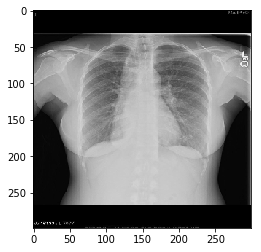

Predicted: 0.97440606 Chest radiograph


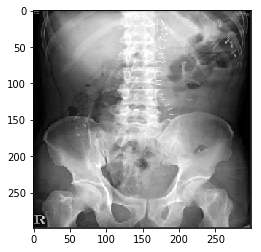

Predicted: 0.0071167643 Abdominal radiograph


In [ ]:
# load example chest and abdominal radiographs from test data set 
img_path = os.path.join(path, 'test/chest_test.png')
img_path2 = os.path.join(path, 'test/abd_test.png')
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))

# show the chest radiograph
plt.imshow(img)
plt.show()

# evaluate the chest radiograph with the model, then print the model's prediction
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0) * 1./255
score = model.predict(x)
print('Predicted:', score[0][0], 'Chest radiograph' if score > 0.5 else 'Abdominal radiograph')

# show the abdominal radiograph
plt.imshow(img2)
plt.show()

# evaluate the abdominal radiograph with the model, then print the model's prediction
img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2[0][0], 'Chest radiograph' if score2 > 0.5 else 'Abdominal radiograph')


## Congrats on completing this demo! 
I hope it has fostered some interest in AI and Machine Learning for Radiology. At the very least, you hopefully know a little more about Machine Learning in Radiology than you did before.

If you're interested, feel free to come back to this kernel and play around with other hyperparameters to gain a little more insight into this topic.

If you really want to get involved in the Radiology AI/ML community, I encourage you to join the [Society for Imaging Informatics in Medicine](https://siim.org/page/rfds_community_inter) (SIIM) Resident, Fellow & Doctoral Student (RFDS) Community and maybe even participate in future **RSNA Kaggle Challenges**. You can even download the data from past challenges to try your hand at training an algorithm. If you're not sure where to begin, the winners' solutions are posted in the **Discussion** tab of the Challenge page.

For an excellent one-week introduction to Imaging Informatics, consider taking the [**RSNA-SIIM** National Imaging Informatics Course](https://sites.google.com/view/imaging-informatics-course/home) offered in October and January of each year.

Thanks for participating! **Finally, if you enjoyed this demo, please remember to up-vote the original kernel on [this page](https://www.kaggle.com/wfwiggins203/hello-world-for-deep-learning-siim).**

Cheers,

**Authors:**<br/>
Walter Wiggins, MD, PhD<sup>1,2,3</sup><br/>
M. Travis Caton, MD<sup>1,2,3</sup><br/>
Kirti Magudia, MD, PhD<sup>1,2,3</sup><br/>
Andreas Rauschecker, MD, PhD<sup>4</sup>

**Faculty Advisors:**<br/>
Kathy Andriole, PhD<sup>1,2</sup> <br/>
Michael Rosenthal, MD, PhD<sup>1,5</sup>

<sup>1</sup>Brigham & Women's Hospital/Harvard Medical School<br/>
<sup>2</sup>MGH-BWH Center for Clinical Data Science<br/>
<sup>3</sup>BWH-CCDS Data Science Pathway<br/>
<sup>4</sup>University of California, San Francisco<br/>
<sup>5</sup>Dana Farber Cancer Institute

**Contact:** Walter Wiggins<br/>
**Email:** [wwiggins@bwh.harvard.edu](mailto:wwiggins@bwh.harvard.edu)<br/>
**Twitter:** [@walterfwiggins](https://www.twitter.com/walterfwiggins)

**Acknowledgments:**
- Thanks to James Condon for the pretrained weights fix.